###Saliency Maps







In [ ]:
# Install packages for compatibility

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

!pip install tf-keras==2.15 --quiet
!pip install tensorflow==2.15 --quiet
!pip install keras==2.15 --quiet

### Download test files and weights

In [ ]:
# Download the same test files from the Cats vs Dogs ungraded lab
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

# Download prepared weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kipXTxesGJKGY1B8uSPRvxROgOH90fih' -O 0_epochs.h5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oiV6tjy5k7h9OHGTQaf0Ohn3FmF-uOs1' -O 15_epochs.h5


--2025-01-22 10:48:08--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K   558KB/s    in 0.7s    

2025-01-22 10:48:08 (558 KB/s) - ‘cat1.jpg’ saved [414826/414826]

--2025-01-22 10:48:09--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat

### Import the required packages

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

### Download and prepare the dataset.



#### Load Cats vs Dogs

* Required: Use Tensorflow Datasets to fetch the `cats_vs_dogs` dataset.
  * Use the first 80% of the *train* split of the said dataset to create your training set.
  * Set the `as_supervised` flag to create `(image, label)` pairs.
    
* Optional: You can create validation and test sets from the remaining 20% of the *train* split of `cats_vs_dogs` (i.e. you already used 80% for the train set). This is if you intend to train the model beyond what is required for submission.

In [ ]:
# Load the data and create the train set (optional: val and test sets)

train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)


#### Create preprocessing function

In [ ]:
def augmentimages(image, label):
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))
  labels = tf.one_hot(label, depth=2)
  return image, labels

#### Preprocess the training set


In [ ]:
augmented_training_data = train_data.map(augmentimages)

#### Create batches of the training set.

In [ ]:
train_batches = augmented_training_data.batch(32)

In [ ]:
for images, labels in train_batches.take(1):  # Prendre un seul batch
    print("Images shape:", images.shape)  # Devrait être (batch_size, 300, 300, 3)
    print("Labels shape:", labels.shape)  # Devrait être (batch_size,)
    print("Labels sample:", labels.numpy())  # Afficher les labels en tant que tableau numpy

Images shape: (32, 300, 300, 3)
Labels shape: (32, 2)
Labels sample: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


### Build the Cats vs Dogs classifier



In [ ]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 37, 37, 64)       

### Create a function to generate the saliency map



In [ ]:
image_file_name = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']

def do_salience(image, model, label, prefix):
  '''
  Generates the saliency map of a given image.

  Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # Read the image and convert channel order from BGR to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
  image = cv2.resize(image, (300, 300))

  # Normalize pixel values to the range [0, 1]
  image = image / 255.0

  # Add an additional dimension (for the batch), and save this in a new variable
  img = np.expand_dims(image, axis=0)

  # Declare the number of classes
  num_classes = 2

  expected_output = tf.one_hot([label] * img.shape[0], num_classes)


  with tf.GradientTape() as tape:

    inputs = tf.cast(img, tf.float32)

    tape.watch(inputs)

    predictions = model(inputs)

    loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

  # get the gradients of the loss with respect to the model's input image
  gradients = tape.gradient(loss, inputs)

  # generate the grayscale tensor
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,)

  # Remove dimensions that are size 1
  normalized_tensor = tf.squeeze(normalized_tensor)


  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalized_tensor, cmap='gray')
  plt.show()

  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  super_imposed = cv2.addWeighted(image, 0.5, gradient_color, 0.5, 0.0)

  plt.figure(figsize=(8, 8))
  plt.imshow(super_imposed)
  plt.axis('off')
  plt.show()

    # Save the normalized tensor image to a file
  salient_image_name = prefix + image_file_name
  normalized_tensor = tf.expand_dims(normalized_tensor, -1)  # Add a channel dimension for grayscale
  encoded_image = tf.io.encode_jpeg(normalized_tensor, format='grayscale')
  tf.io.write_file(salient_image_name, encoded_image)

### Generate saliency maps with untrained model


In [ ]:
# load initial weights
model.load_weights('0_epochs.h5')
# generate the saliency maps for the 5 test images
# List of image files and their labels
image_files = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']
l = [0, 0, 0, 1, 1]  # Cats have label 0, dogs have label 1

# Loop through each image and generate saliency maps
for i, image_file in enumerate(image_files):
    # Load and preprocess the image
    image = cv2.imread(image_file)

    # Generate saliency map
    do_salience(image, model, l[i], 'epoch0_salient')


With untrained weights, you will see something like this in the output.
- You will see strong pixels outside the cat that the model uses that when classifying the image.
- After training that these will slowly start to localize to features inside the pet.

<img src='https://drive.google.com/uc?export=view&id=1h5wP52lwbBUMVLlsgyb-tQl_I9eu42X7' alt='saliency'>


### Configure the model for training

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',  # Appropriate loss function for binary classification with integer labels
    metrics=['accuracy']         # Metrics to evaluate during training and testing
)

### Train our model


In [ ]:
# load pre-trained weights
model.load_weights('15_epochs.h5')
# train the model for just 3 epochs
model.fit(train_batches,epochs=10)

Epoch 1/10
582/582 [==============================] - 46s 77ms/step - loss: 0.4562 - accuracy: 0.7959
Epoch 2/10
582/582 [==============================] - 39s 68ms/step - loss: 0.4435 - accuracy: 0.8031
Epoch 3/10
582/582 [==============================] - 39s 68ms/step - loss: 0.4343 - accuracy: 0.8080
Epoch 4/10
582/582 [==============================] - 40s 69ms/step - loss: 0.4251 - accuracy: 0.8121
Epoch 5/10
582/582 [==============================] - 39s 68ms/step - loss: 0.4168 - accuracy: 0.8169
Epoch 6/10
582/582 [==============================] - 40s 68ms/step - loss: 0.4091 - accuracy: 0.8221
Epoch 7/10
582/582 [==============================] - 42s 71ms/step - loss: 0.4013 - accuracy: 0.8260
Epoch 8/10
582/582 [==============================] - 39s 67ms/step - loss: 0.3951 - accuracy: 0.8294
Epoch 9/10
582/582 [==============================] - 47s 81ms/step - loss: 0.3879 - accuracy: 0.8337
Epoch 10/10
582/582 [==============================] - 43s 74ms/step - loss: 0.381

### Generate saliency maps at 25 epochs


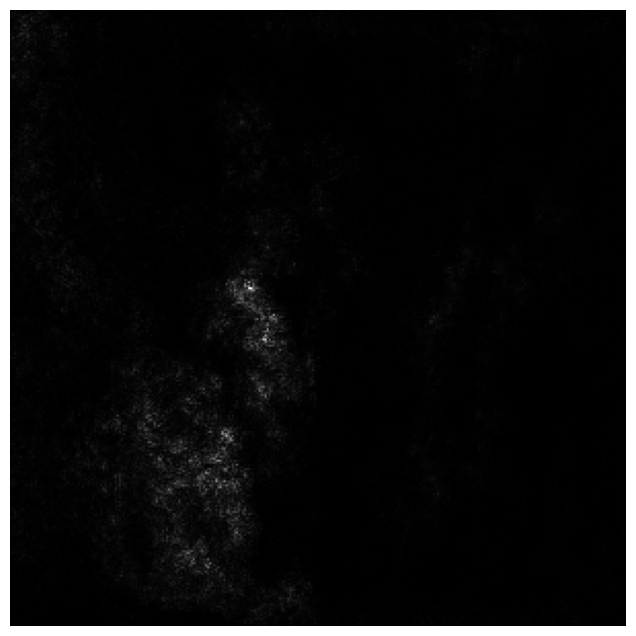

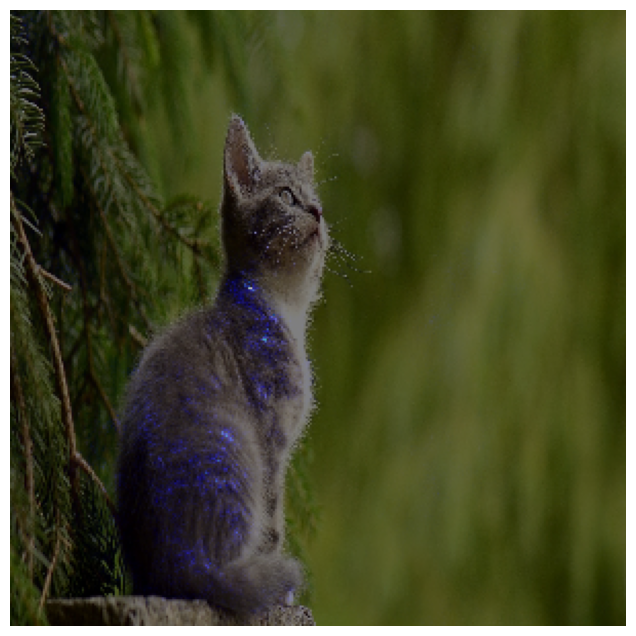

Saved saliency map as salient_cat1.jpg


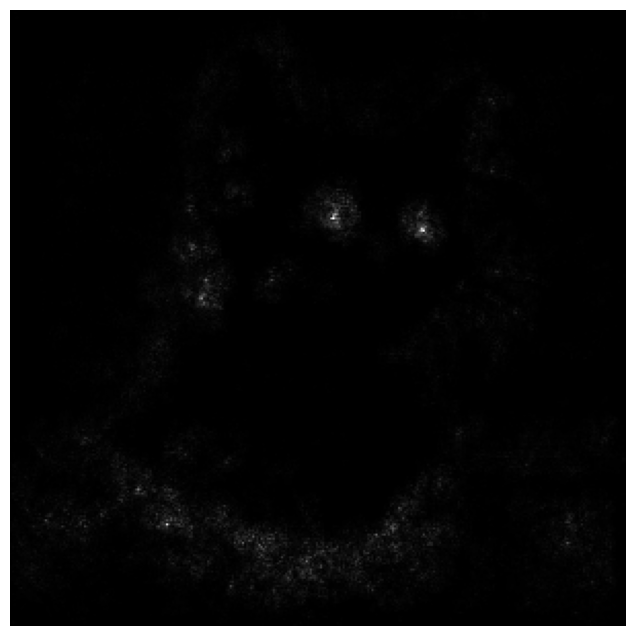

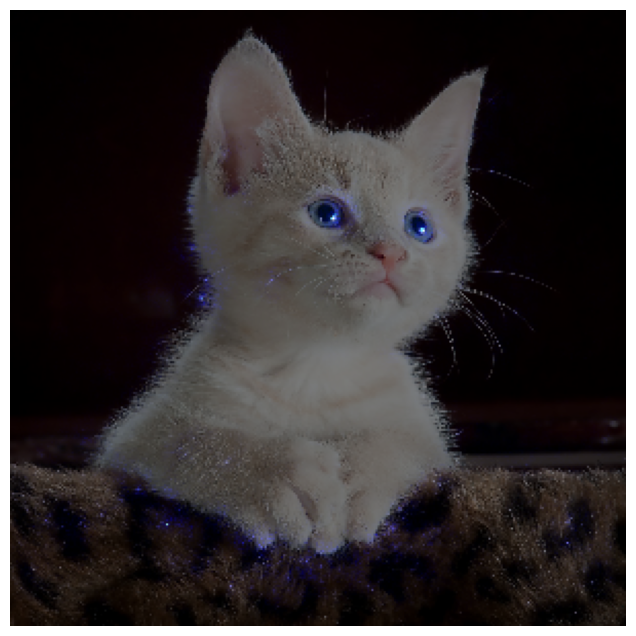

Saved saliency map as salient_cat2.jpg


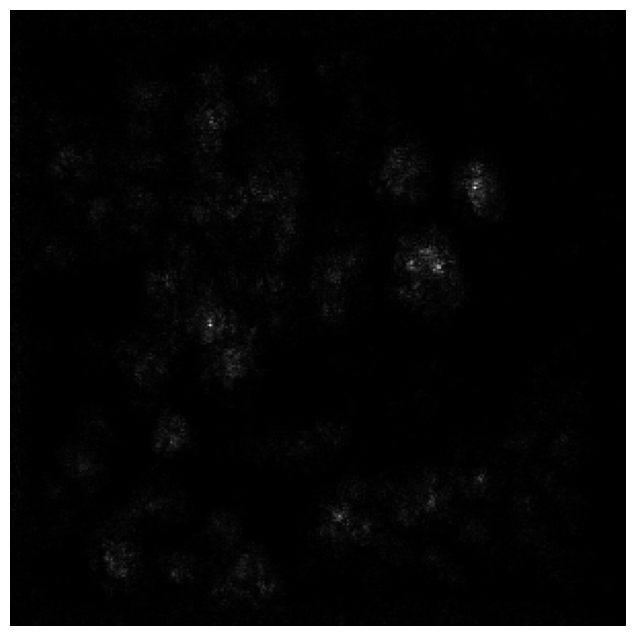

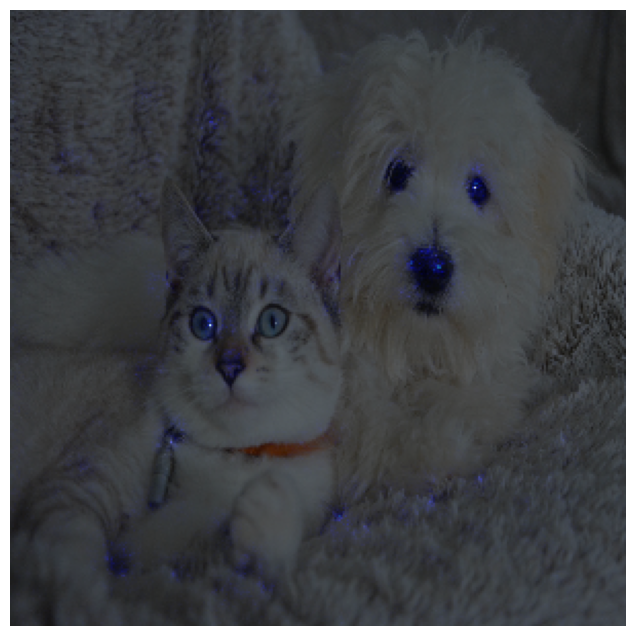

Saved saliency map as salient_catanddog.jpg


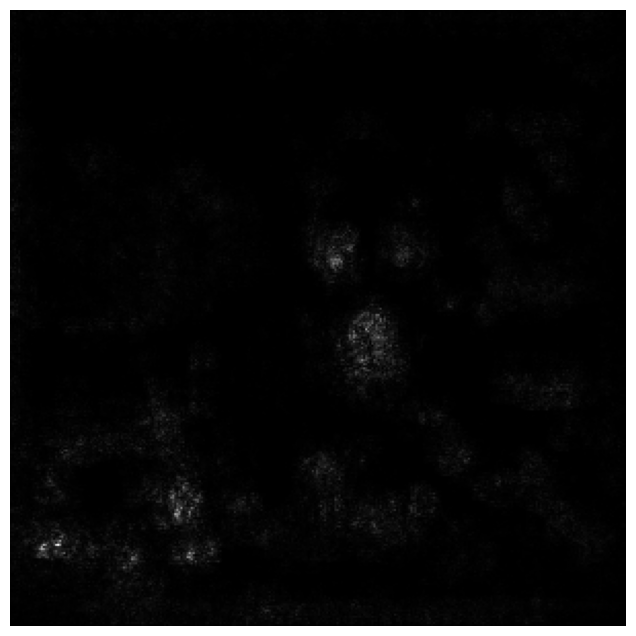

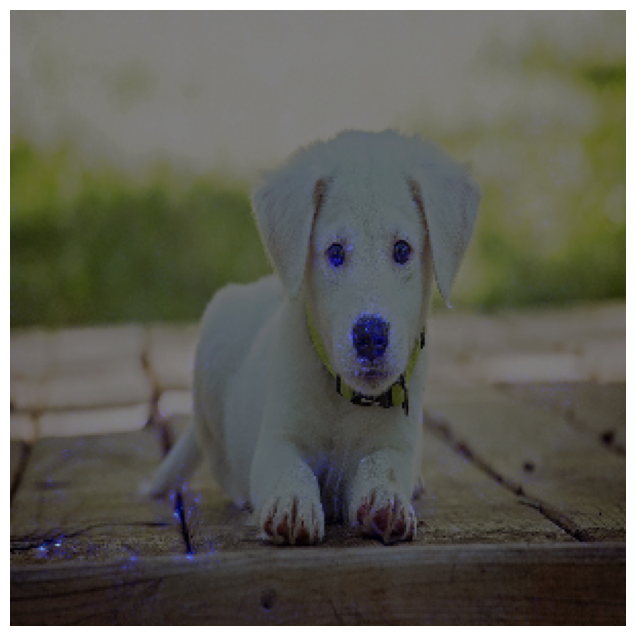

Saved saliency map as salient_dog1.jpg


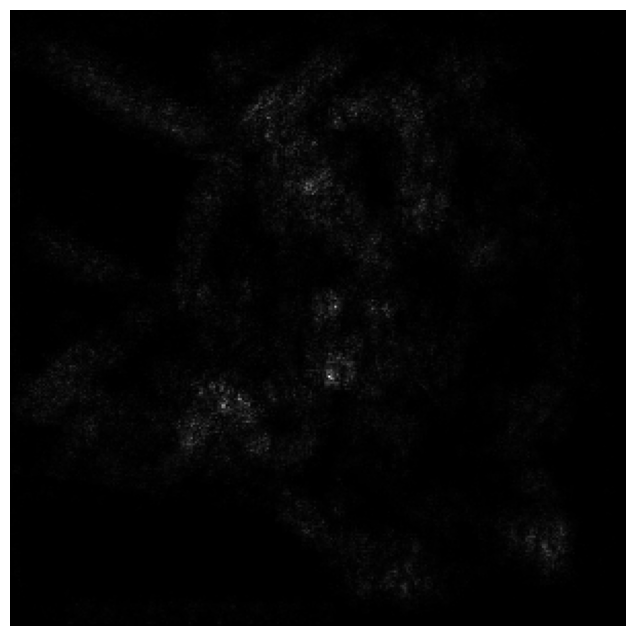

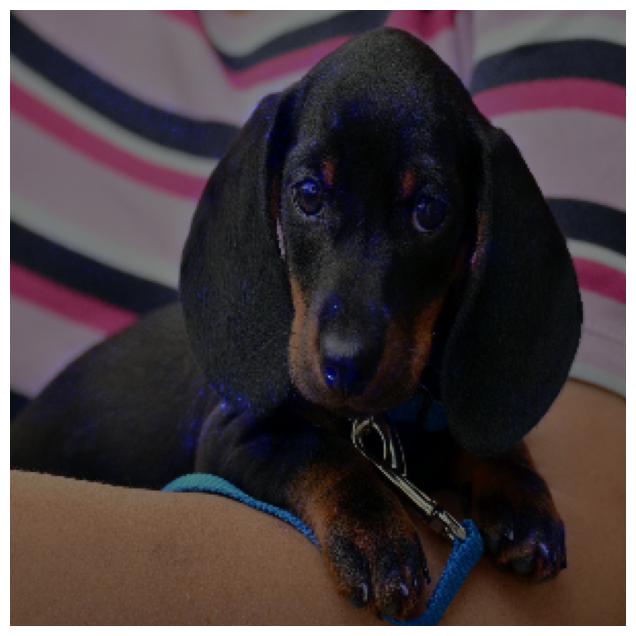

Saved saliency map as salient_dog2.jpg


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# List of image files
image_files = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']

# Labels corresponding to each image (0 for cats, 1 for dogs)
labels = [0, 0, 0, 1, 1]  # Ensure labels correspond to the images in image_files

def do_salience(image, model, label, prefix):
    '''
    Generates the saliency map of a given image.

    Args:
      image (file) -- picture that the model will classify
      model (keras Model) -- your cats and dogs classifier
      label (int) -- ground truth label of the image
      prefix (string) -- prefix to add to the filename of the saliency map
    '''

    # Read the image and convert channel order from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
    image = cv2.resize(image, (300, 300))
    image = image / 255.0

    # Add an additional dimension (for the batch), and save this in a new variable
    img = np.expand_dims(image, axis=0)

    # Declare the number of classes
    num_classes = 2

    # Define the expected output array by one-hot encoding the label
    expected_output = tf.one_hot([label] * img.shape[0], num_classes)

    # Compute saliency map using GradientTape
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(img, dtype=tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

    # Get gradients of the loss w.r.t the input image
    gradients = tape.gradient(loss, inputs)

    # Generate the grayscale tensor by summing the absolute gradients
    grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

    # Normalize the grayscale tensor to [0, 255]
    min_val = tf.reduce_min(grayscale_tensor)
    max_val = tf.reduce_max(grayscale_tensor)
    normalized_tensor = tf.cast(
        255 * (grayscale_tensor - min_val) / (max_val - min_val),
        tf.uint8
    )

    # Remove dimensions of size 1
    normalized_tensor = tf.squeeze(normalized_tensor)

    # Plot the grayscale saliency map
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(normalized_tensor, cmap='gray')
    plt.show()

    # Optional: Superimpose the saliency map with the original image
    gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
    gradient_color = gradient_color / 255.0
    super_imposed = cv2.addWeighted(image, 0.5, gradient_color, 0.5, 0.0)

    plt.figure(figsize=(8, 8))
    plt.imshow(super_imposed)
    plt.axis('off')
    plt.show()

    # Save the normalized tensor image to a file
    salient_image_name = prefix + image_file.split('/')[-1]  # Correctly generate the filename
    normalized_tensor = tf.expand_dims(normalized_tensor, -1)  # Add a channel dimension for grayscale
    encoded_image = tf.io.encode_jpeg(normalized_tensor, format='grayscale')
    tf.io.write_file(salient_image_name, encoded_image)
    print(f'Saved saliency map as {salient_image_name}')

# Loop through each image and generate saliency maps
for i, image_file in enumerate(image_files):
    # Load and preprocess the image
    image = cv2.imread(image_file)

    # Generate saliency map
    do_salience(image, model, labels[i], 'salient_')


You should see that the strong pixels are now very less than the ones you generated earlier. Moreover, most of them are now found on features within the pet.